# Segmenting and Clustering Neighborhoods in Toronto

## Part 1: Scraping and Preprocessing

1.1 Installing and importing prerequisite libraries.

In [1]:
#!pip install bs4
from bs4 import BeautifulSoup

import requests
import pandas as pd
import requests

#!pip install folium
import folium

#!pip install sklearn
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

import numpy as np

1.2 Start by scraping wikipedia page.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
TPC_data  = requests.get(url).text
TPC_soup = BeautifulSoup(TPC_data, 'html.parser')

1.3 Find table and clean contents.

In [3]:
TPC_table = TPC_soup.find('table')
TPC_table_contents = []
for row in TPC_table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        TPC_table_contents.append(cell)

1.4 Store the table data in a dataframe and group by neighborhood.

In [4]:
TPC_df=pd.DataFrame(TPC_table_contents)
TPC_df['Borough']=TPC_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A', 'East TorontoBusiness reply mail Processing Centre969 Eastern':
                                             'East Toronto Business','EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df_postcode = TPC_df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()

1.5 Display dataframe with with postalcode, borough, and neighborhood, and display the dataframe shape.

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 39):
    print(df_postcode)
df_postcode.shape

    PostalCode                 Borough                            Neighborhood
0          M1B             Scarborough                          Malvern, Rouge
1          M1C             Scarborough  Rouge Hill, Port Union, Highland Creek
2          M1E             Scarborough       Guildwood, Morningside, West Hill
3          M1G             Scarborough                                  Woburn
4          M1H             Scarborough                               Cedarbrae
5          M1J             Scarborough                     Scarborough Village
6          M1K             Scarborough  Kennedy Park, Ionview, East Birchmo...
7          M1L             Scarborough         Golden Mile, Clairlea, Oakridge
8          M1M             Scarborough  Cliffside, Cliffcrest, Scarborough ...
9          M1N             Scarborough             Birch Cliff, Cliffside West
10         M1P             Scarborough  Dorset Park, Wexford Heights, Scarb...
11         M1R             Scarborough              

(103, 3)

## Part 2: Implementing Geographical Coordinate Information

2.1 Import the geographical coordinates of each postal code.

In [6]:
locgeo_df = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code')

2.2 Create data frame with geographical coordinates and previous information together.

In [7]:
toronto_data = df_postcode.join(locgeo_df, on='PostalCode')

2.3 Output the dataframe and shape.

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 20):
    print(toronto_data)
toronto_data.shape

    PostalCode              Borough         Neighborhood   Latitude  Longitude
0          M1B          Scarborough       Malvern, Rouge  43.806686 -79.194353
1          M1C          Scarborough  Rouge Hill, Port...  43.784535 -79.160497
2          M1E          Scarborough  Guildwood, Morni...  43.763573 -79.188711
3          M1G          Scarborough               Woburn  43.770992 -79.216917
4          M1H          Scarborough            Cedarbrae  43.773136 -79.239476
5          M1J          Scarborough  Scarborough Village  43.744734 -79.239476
6          M1K          Scarborough  Kennedy Park, Io...  43.727929 -79.262029
7          M1L          Scarborough  Golden Mile, Cla...  43.711112 -79.284577
8          M1M          Scarborough  Cliffside, Cliff...  43.716316 -79.239476
9          M1N          Scarborough  Birch Cliff, Cli...  43.692657 -79.264848
10         M1P          Scarborough  Dorset Park, Wex...  43.757410 -79.273304
11         M1R          Scarborough    Wexford, Mary

(103, 5)

## Part 3: Exploring and clustering neighborhoods in Toronto

3.1 Initializaing Foursquare API.

In [9]:
CLIENT_ID = 'D1OA3GICFE0DQBPVFGT1LXPMECFEYX32MIAUWEDCIEDKDSAO' # your Foursquare ID
CLIENT_SECRET = 'FYYWHEPCUN43OZ344ZDXL5IHHZPHWL4J3P2V3JTQ2SLU1BTQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

3.2 Define function for getting nearby venues.

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

3.3 Using the function to get toronto venues.

In [11]:
toronto_venues = getNearbyVenues(toronto_data['Neighborhood'], toronto_data['Latitude'], toronto_data['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


3.4 One hot encoding venues in neighborhoods.

In [12]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

3.5 Grouping by neighborhood and defining a function for picking most common venues.

In [13]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

3.6 Organizing data for clustering.

In [14]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

3.7 Clustering data.

In [15]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0])

3.8 Combining cluster data to dataframe and cleaning it.

In [16]:
#### add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# removing neiborhoods that did not have any foursquare query responses
toronto_merged.dropna(inplace = True)

3.9 Creating map of clustered data for visualization.

In [17]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster) - 1],
        fill=True,
        fill_color=rainbow[int(cluster) - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Image of Toronto Clustered for viewing on GitHub (notebook not trusted).
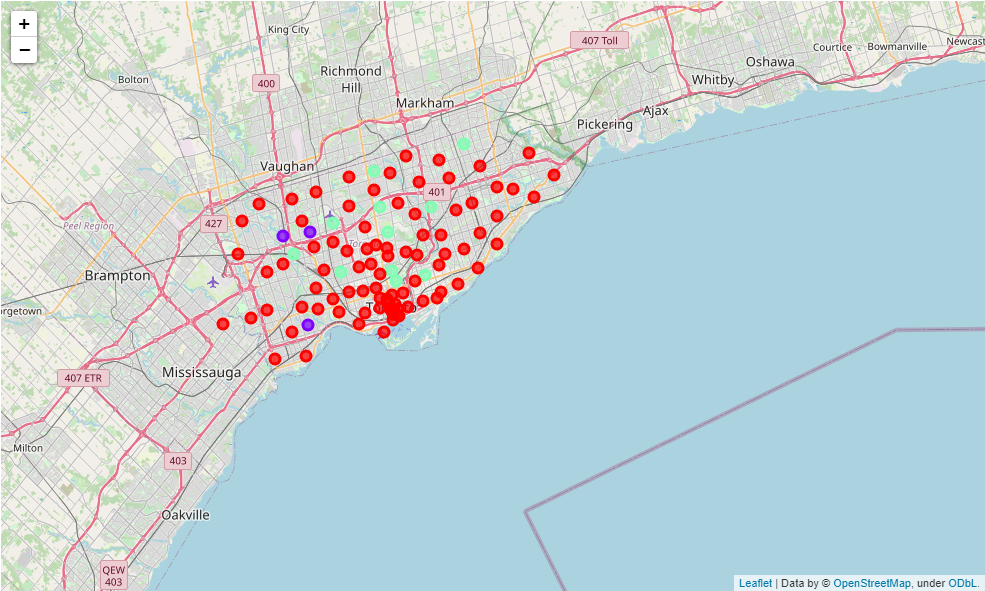